# Ejemplo aplicado de Threshold VAR (TVAR)

Este notebook ilustra cómo utilizar un modelo vectorial autorregresivo con umbral para analizar la no linealidad en series de tiempo económicas. Se trabaja con el conjunto de datos macroeconómicos `macrodata` de statsmodels, que contiene variables trimestrales de Estados Unidos.

In [3]:
# Importar paquetes necesarios
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.datasets import macrodata

# Configuraciones de visualización
pd.set_option('display.max_columns', None)
#plt.style.use('seaborn-darkgrid')


## Carga y preparación de datos

Se carga la base de datos, se crea un índice temporal trimestral y se visualizan las primeras observaciones.

In [4]:
# Cargar datos y crear índice temporal trimestral
data = macrodata.load_pandas().data.copy()
# Crear un índice de periodos trimestrales desde 1959Q1
data['date'] = pd.period_range(start='1959Q1', periods=len(data), freq='Q')
data.set_index('date', inplace=True)
# Mostrar las primeras filas
data.head()


,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
date,,,,,,,,,,,,,,
1959Q1,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959Q2,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959Q3,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959Q4,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960Q1,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


## Transformaciones y selección de variables

Para estimar un VAR se suelen utilizar tasas de crecimiento o diferencias de las variables para garantizar la estacionariedad.
Se construyen las siguientes variables:
- **Crecimiento del PIB real**: variación porcentual trimestral de `realgdp`.
- **Inflación**: tasa trimestral de inflación a partir de `gdp` (deflactor implícito).
- **Desempleo**: la tasa de desempleo `unemp` se utiliza como variable de umbral.
- **Tasa de interés real**: se calcula como `tbilrate` menos la inflación.

In [6]:
# Crear variables transformadas
# Crecimiento del PIB real
data['growth_gdp'] = data['realgdp'].pct_change() * 100
# Inflación (deflactor implícito)
data['inflation'] = data['cpi'].pct_change() * 100
# Tasa de interés real (tasa T-bill a 3 meses menos inflación)
data['real_rate'] = data['tbilrate'] - data['inflation']
# Seleccionar desempleo
data['unemp'] = data['unemp']
# Eliminar observaciones iniciales con NA
df = data[['growth_gdp', 'inflation', 'unemp', 'real_rate']].dropna().copy()
df.head()


,growth_gdp,inflation,unemp,real_rate
date,,,,
1959Q2,2.525579,0.586611,5.1,2.493389
1959Q3,-0.119224,0.686106,5.3,3.133894
1959Q4,0.350065,0.068143,5.6,4.261857
1960Q1,2.243821,0.578822,5.2,2.921178
1960Q2,-0.467360,0.033852,5.2,2.646148


## Análisis exploratorio

Se grafican las series de tiempo transformadas para identificar patrones, tendencias y posibles cambios de régimen.

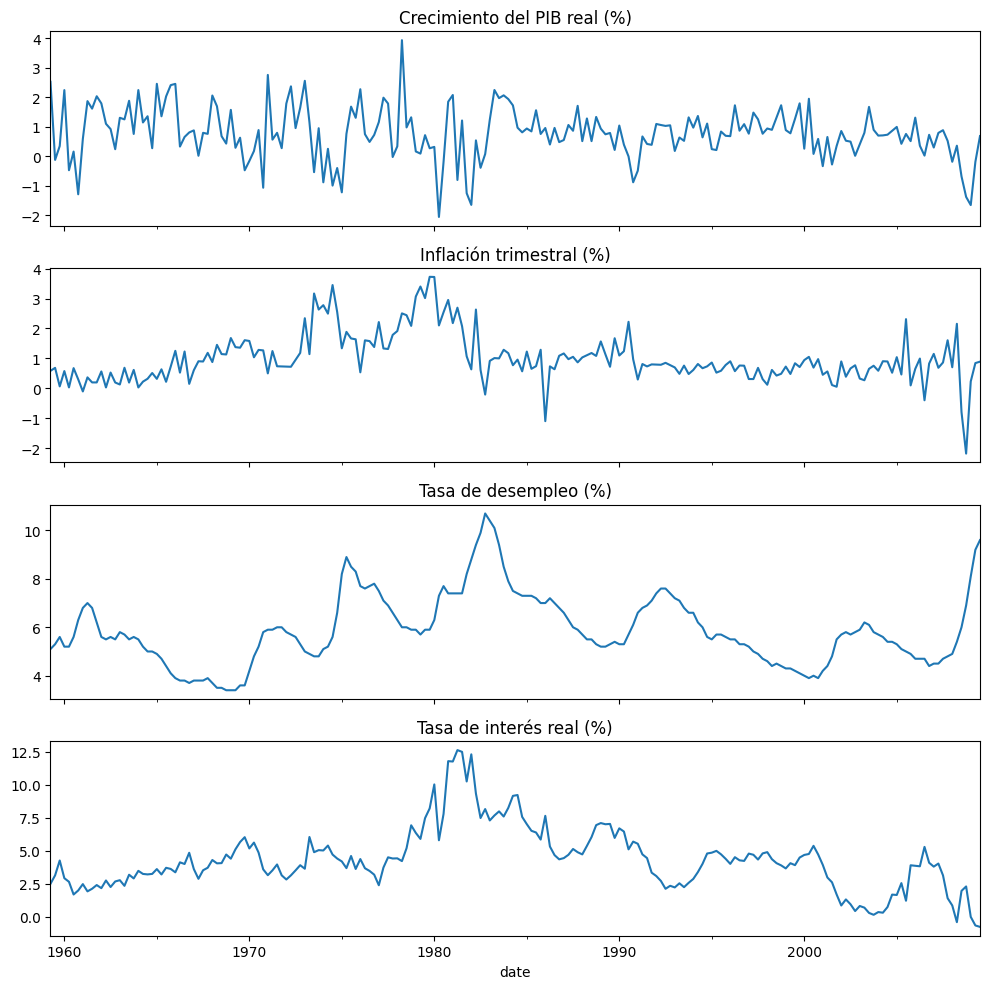

In [7]:
# Graficar las series transformadas
fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
df['growth_gdp'].plot(ax=axes[0], title='Crecimiento del PIB real (%)')
df['inflation'].plot(ax=axes[1], title='Inflación trimestral (%)')
df['unemp'].plot(ax=axes[2], title='Tasa de desempleo (%)')
df['real_rate'].plot(ax=axes[3], title='Tasa de interés real (%)')
plt.tight_layout()
plt.show()


## Selección del orden del VAR

Se utiliza un modelo VAR lineal como punto de partida para elegir el número de rezagos óptimo usando el criterio de información de Akaike (AIC).

In [8]:
# Estimar VAR lineal y seleccionar el orden de rezagos
model = VAR(df[['growth_gdp', 'inflation', 'unemp', 'real_rate']])
results = model.select_order(maxlags=8)
results.summary()


,AIC,BIC,FPE,HQIC
0,1.679,1.746,5.359,1.706
1,-4.955,-4.618,0.007051,-4.818
2,-5.392,-4.786*,0.004553,-5.147*
3,-5.489,-4.613,0.004136,-5.134
4,-5.497,-4.351,0.004108,-5.033
5,-5.467,-4.052,0.004238,-4.894
6,-5.503*,-3.818,0.004099*,-4.821
7,-5.401,-3.447,0.004555,-4.609
8,-5.388,-3.164,0.004634,-4.487


In [9]:
# Ajustar el VAR con el número de rezagos seleccionado por AIC
p_opt = results.aic
var_model = model.fit(p_opt)
var_model.summary()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 08, Oct, 2025
Time:                     02:28:19
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -3.82182
Nobs:                     196.000    HQIC:                  -4.81722
Log likelihood:          -474.004    FPE:                 0.00413305
AIC:                     -5.49433    Det(Omega_mle):      0.00255697
--------------------------------------------------------------------
Results for equation growth_gdp
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.255485         0.361941            0.706           0.480
L1.growth_gdp         0.091426         0.088459            1.034           0.301
L1.inflation          0.100896         0.113398        

## Búsqueda del valor umbral

Para construir un TVAR se selecciona una variable de umbral (aquí, el desempleo retrasado) y se busca un valor de corte `r` que minimice la suma de errores al ajustar modelos por separado en cada régimen.
Se exploran varios percentiles de la distribución de `unemp` como candidatos.

In [10]:
# Definir la variable de umbral (desempleo retardado 1 período)
threshold_var = df['unemp'].shift(1).dropna()
# Alinear variables dependientes con el threshold retardado
df_aligned = df.loc[threshold_var.index]
threshold_var = threshold_var.loc[df_aligned.index]
# Candidatos de umbral entre percentiles 10 y 90
percentiles = np.linspace(0.10, 0.90, 20)
candidates = np.percentile(threshold_var, percentiles * 100)

def calculate_sse(threshold):
    lower_regime = df_aligned[threshold_var <= threshold]
    upper_regime = df_aligned[threshold_var > threshold]
    sse = 0
    for subset in [lower_regime, upper_regime]:
        if len(subset) < 10:
            return np.inf
        res = VAR(subset).fit(p_opt)
        sse += np.sum(res.resid.values**2)
    return sse

sse_values = [calculate_sse(c) for c in candidates]
optimal_threshold = candidates[int(np.argmin(sse_values))]
optimal_threshold


7.2

## Estimación de modelos por régimen

Con el umbral seleccionado se separan las observaciones en dos regímenes (alto y bajo desempleo) y se ajustan modelos VAR por separado.

In [12]:
# Particionar datos según el umbral óptimo
lower_df = df_aligned[threshold_var <= optimal_threshold]
upper_df = df_aligned[threshold_var > optimal_threshold]
# Ajustar VAR en cada régimen
model_low = VAR(lower_df).fit(p_opt)
model_high = VAR(upper_df).fit(p_opt)
print('VAR – régimen de bajo desempleo')
print(model_low.summary())
print('VAR – régimen de alto desempleo')
print(model_high.summary())


VAR – régimen de bajo desempleo
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 08, Oct, 2025
Time:                     02:28:37
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -3.37872
Nobs:                     159.000    HQIC:                  -4.52504
Log likelihood:          -380.391    FPE:                 0.00499996
AIC:                     -5.30885    Det(Omega_mle):      0.00278794
--------------------------------------------------------------------
Results for equation growth_gdp
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.037709         0.549794           -0.069           0.945
L1.growth_gdp         0.198770         0.098611            2.016           0.044
L1.inflation         -0

## Diagnósticos y validación

Se revisan las autocorrelaciones de los residuos en cada régimen como chequeo de ajuste. Un modelo bien especificado debería mostrar residuos que se comportan como ruido blanco.

InvalidIndexError: (slice(None, None, None), 0)

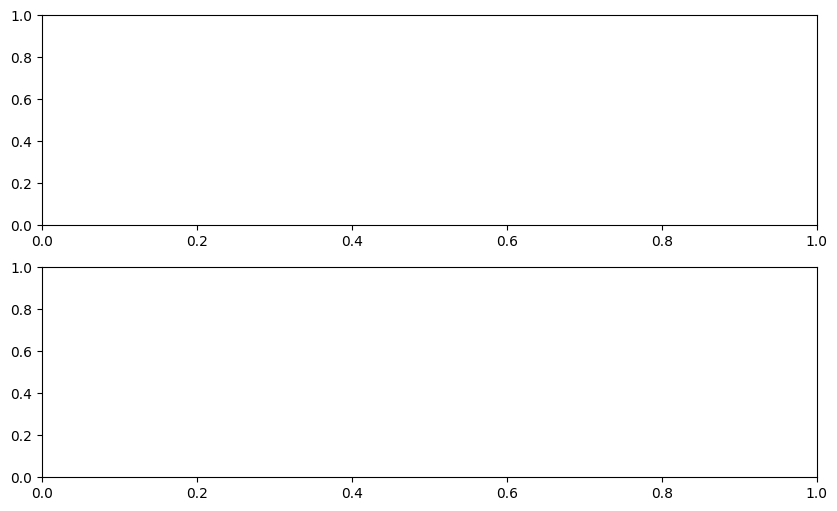

In [13]:
# Graficar autocorrelaciones de los residuos del primer componente
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(model_low.resid[:, 0], ax=axes[0], lags=20)
axes[0].set_title('ACF de residuos – régimen bajo desempleo (variable 1)')
plot_acf(model_high.resid[:, 0], ax=axes[1], lags=20)
axes[1].set_title('ACF de residuos – régimen alto desempleo (variable 1)')
plt.tight_layout()
plt.show()


## Conclusión

Este ejemplo mostró cómo implementar un Threshold VAR de dos regímenes en Python. La metodología incluye la selección del orden del VAR, la búsqueda de un umbral óptimo y la estimación de modelos por separado. Aunque se utilizó una muestra limitada, sirve para ilustrar la detección de cambios de régimen y la importancia de los supuestos (estacionariedad, tamaño de muestra y variable de umbral adecuada).